In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

# ============================================================================
# CONFIGURATION DEVICE
# ============================================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")

✓ Using device: cuda


In [2]:
# ============================================================================
# PART 1: CHARGEMENT DU DATASET MNIST
# ============================================================================
print("\n" + "="*80)
print("PART 1: CHARGEMENT DU DATASET MNIST")
print("="*80)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

print("Téléchargement du dataset MNIST...")
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)

print(f"✓ Dataset MNIST chargé avec succès")
print(f"  - Samples d'entraînement: {len(train_dataset)}")
print(f"  - Samples de test: {len(test_dataset)}")
print(f"  - Taille image: 28x28")
print(f"  - Nombre de classes: 10")


PART 1: CHARGEMENT DU DATASET MNIST
Téléchargement du dataset MNIST...


100%|██████████| 9.91M/9.91M [00:00<00:00, 34.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.02MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.16MB/s]

✓ Dataset MNIST chargé avec succès
  - Samples d'entraînement: 60000
  - Samples de test: 10000
  - Taille image: 28x28
  - Nombre de classes: 10


In [3]:
# ============================================================================
# PART 2: ARCHITECTURE VISION TRANSFORMER FROM SCRATCH
# ============================================================================
print("\n" + "="*80)
print("PART 2: ARCHITECTURE VISION TRANSFORMER (ViT) FROM SCRATCH")
print("="*80)

class PatchEmbedding(nn.Module):
    """Convertit une image en patches et les embed"""
    def __init__(self, img_size=28, patch_size=4, in_channels=1, embed_dim=128):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        # Convolution pour projeter les patches
        self.proj = nn.Conv2d(in_channels, embed_dim, 
                             kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        # x: (B, C, H, W) -> (B, embed_dim, H/patch_size, W/patch_size)
        x = self.proj(x)
        # Flatten et transpose: (B, embed_dim, num_patches) -> (B, num_patches, embed_dim)
        x = x.flatten(2).transpose(1, 2)
        return x


class MultiHeadAttention(nn.Module):
    """Multi-Head Self-Attention"""
    def __init__(self, embed_dim=128, num_heads=8, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        assert embed_dim % num_heads == 0, "embed_dim doit être divisible par num_heads"
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(proj_drop)
    
    def forward(self, x):
        B, N, C = x.shape
        # QKV projection
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Attention
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        # Combinaison des heads
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class TransformerBlock(nn.Module):
    """Transformer Block = LayerNorm + MHA + LayerNorm + MLP"""
    def __init__(self, embed_dim=128, num_heads=8, mlp_dim=256, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout, dropout)
        
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        # Residual connection avec attention
        x = x + self.attn(self.norm1(x))
        # Residual connection avec MLP
        x = x + self.mlp(self.norm2(x))
        return x


class VisionTransformer(nn.Module):
    """Vision Transformer pour classification"""
    def __init__(self, img_size=28, patch_size=4, num_classes=10, 
                 embed_dim=128, num_heads=8, depth=6, mlp_dim=256, dropout=0.1):
        super().__init__()
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, 1, embed_dim)
        num_patches = self.patch_embed.num_patches
        
        # Class token et position embedding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Transformer blocks
        self.transformer = nn.Sequential(*[
            TransformerBlock(embed_dim, num_heads, mlp_dim, dropout)
            for _ in range(depth)
        ])
        
        # Classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        # Initialisation des poids
        nn.init.normal_(self.pos_embed, std=0.02)
        nn.init.normal_(self.cls_token, std=0.02)
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)
    
    def forward(self, x):
        B = x.shape[0]
        
        # Patch embedding
        x = self.patch_embed(x)  # (B, num_patches, embed_dim)
        
        # Add class token
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_token, x], dim=1)  # (B, num_patches+1, embed_dim)
        
        # Add position embedding
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        # Transformer blocks
        x = self.transformer(x)
        
        # Classification (utiliser uniquement le CLS token)
        x = self.norm(x)
        x = x[:, 0]  # CLS token
        x = self.head(x)
        
        return x


PART 2: ARCHITECTURE VISION TRANSFORMER (ViT) FROM SCRATCH


In [4]:
# ============================================================================
# PART 3: MODÈLES DE COMPARAISON (CNN SIMPLE)
# ============================================================================
print("\n" + "="*80)
print("PART 3: MODÈLES DE COMPARAISON")
print("="*80)

class SimpleCNN(nn.Module):
    """CNN simple pour comparaison"""
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


PART 3: MODÈLES DE COMPARAISON


In [6]:
# ============================================================================
# FONCTIONS D'ENTRAÎNEMENT ET ÉVALUATION
# ============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Entraîne le modèle pour une epoch"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100.0 * correct / total
    
    return avg_loss, accuracy


def evaluate(model, dataloader, criterion, device):
    """Évalue le modèle"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100.0 * correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1, all_preds, all_labels


def train_model(model, model_name, train_loader, test_loader, num_epochs=20, lr=0.001):
    """Entraîne un modèle"""
    print(f"\n--- Training {model_name} ---")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # Compter les paramètres
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Nombre de paramètres: {total_params:,}")
    
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    best_acc = 0
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc, _, _, _ = evaluate(model, test_loader, criterion, device)
        
        scheduler.step()
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1:2d}/{num_epochs} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:6.2f}% | "
                  f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:6.2f}%")
        
        if test_acc > best_acc:
            best_acc = test_acc
    
    training_time = time.time() - start_time
    
    # Évaluation finale
    final_loss, final_acc, final_f1, preds, labels = evaluate(model, test_loader, criterion, device)
    
    return {
        'model': model,
        'name': model_name,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'test_accs': test_accs,
        'final_accuracy': final_acc,
        'final_f1': final_f1,
        'training_time': training_time,
        'parameters': total_params,
        'predictions': preds,
        'labels': labels
    }

In [7]:
# ============================================================================
# ENTRAÎNEMENT DES MODÈLES
# ============================================================================
print("\nEntraînement des modèles en cours...\n")

# Vision Transformer
vit_model = VisionTransformer(
    img_size=28,
    patch_size=4,
    num_classes=10,
    embed_dim=128,
    num_heads=8,
    depth=6,
    mlp_dim=256,
    dropout=0.1
)

vit_results = train_model(vit_model, "Vision Transformer (ViT)", 
                          train_loader, test_loader, num_epochs=20, lr=0.001)

# CNN Simple
cnn_model = SimpleCNN(num_classes=10)
cnn_results = train_model(cnn_model, "Simple CNN", 
                         train_loader, test_loader, num_epochs=20, lr=0.001)


Entraînement des modèles en cours...


--- Training Vision Transformer (ViT) ---
Nombre de paramètres: 805,130


Epoch  5/20 | Train Loss: 0.1116 | Train Acc:  96.40% | Test Loss: 0.1050 | Test Acc:  97.02%


Epoch 10/20 | Train Loss: 0.0540 | Train Acc:  98.24% | Test Loss: 0.0583 | Test Acc:  98.22%


Epoch 15/20 | Train Loss: 0.0200 | Train Acc:  99.37% | Test Loss: 0.0488 | Test Acc:  98.54%


Epoch 20/20 | Train Loss: 0.0085 | Train Acc:  99.77% | Test Loss: 0.0423 | Test Acc:  98.72%



--- Training Simple CNN ---
Nombre de paramètres: 390,410


Epoch  5/20 | Train Loss: 0.0284 | Train Acc:  99.12% | Test Loss: 0.0235 | Test Acc:  99.24%


Epoch 10/20 | Train Loss: 0.0112 | Train Acc:  99.64% | Test Loss: 0.0204 | Test Acc:  99.33%


Epoch 15/20 | Train Loss: 0.0032 | Train Acc:  99.90% | Test Loss: 0.0191 | Test Acc:  99.51%


Epoch 20/20 | Train Loss: 0.0015 | Train Acc:  99.97% | Test Loss: 0.0196 | Test Acc:  99.50%


In [10]:
# ============================================================================
# PART 4: RÉSULTATS ET COMPARAISON
# ============================================================================
print("\n" + "="*80)
print("PART 4: RÉSULTATS ET COMPARAISON DÉTAILLÉE")
print("="*80)

# Tableau comparatif
print("\n" + "-"*80)
print(f"{'Métrique':<30} {'Vision Transformer':<25} {'Simple CNN':<25}")
print("-"*80)

results_data = {
    'Vision Transformer': vit_results,
    'Simple CNN': cnn_results
}

for metric_name, metric_func in [
    ('Accuracy (%)', lambda r: f"{r['final_accuracy']:.4f}"),
    ('F1 Score', lambda r: f"{r['final_f1']:.4f}"),
    ('Nombre de paramètres', lambda r: f"{r['parameters']:,}"),
    ('Temps d\'entraînement (s)', lambda r: f"{r['training_time']:.2f}")
]:
    vit_val = metric_func(vit_results)
    cnn_val = metric_func(cnn_results)
    print(f"{metric_name:<30} {vit_val:<25} {cnn_val:<25}")

print("-"*80)

# Analyse détaillée
print("\n" + "="*80)
print("ANALYSE DÉTAILLÉE DES RÉSULTATS")
print("="*80)

print("\n1. PERFORMANCE D'ACCURACY:")
acc_diff = vit_results['final_accuracy'] - cnn_results['final_accuracy']
print(f"   Vision Transformer: {vit_results['final_accuracy']:.4f}%")
print(f"   Simple CNN: {cnn_results['final_accuracy']:.4f}%")
print(f"   Différence: {acc_diff:+.4f}% {'(ViT gagne)' if acc_diff > 0 else '(CNN gagne)'}")

print("\n2. EFFICACITÉ COMPUTATIONNELLE:")
time_diff = vit_results['training_time'] - cnn_results['training_time']
print(f"   Vision Transformer: {vit_results['training_time']:.2f}s")
print(f"   Simple CNN: {cnn_results['training_time']:.2f}s")
print(f"   Différence: {time_diff:+.2f}s {'(ViT + rapide)' if time_diff < 0 else '(CNN + rapide)'}")

print("\n3. COMPLEXITÉ DU MODÈLE:")
param_ratio = vit_results['parameters'] / cnn_results['parameters']
print(f"   Vision Transformer: {vit_results['parameters']:,} paramètres")
print(f"   Simple CNN: {cnn_results['parameters']:,} paramètres")
print(f"   Ratio (ViT/CNN): {param_ratio:.2f}x")

print("\n4. F1 SCORE (Performance moyenne pondérée):")
f1_diff = vit_results['final_f1'] - cnn_results['final_f1']
print(f"   Vision Transformer: {vit_results['final_f1']:.4f}")
print(f"   Simple CNN: {cnn_results['final_f1']:.4f}")
print(f"   Différence: {f1_diff:+.4f}")


PART 4: RÉSULTATS ET COMPARAISON DÉTAILLÉE

--------------------------------------------------------------------------------
Métrique                       Vision Transformer        Simple CNN               
--------------------------------------------------------------------------------
Accuracy (%)                   98.7200                   99.5000                  
F1 Score                       0.9872                    0.9950                   
Nombre de paramètres           805,130                   390,410                  
Temps d'entraînement (s)       569.12                    346.65                   
--------------------------------------------------------------------------------

ANALYSE DÉTAILLÉE DES RÉSULTATS

1. PERFORMANCE D'ACCURACY:
   Vision Transformer: 98.7200%
   Simple CNN: 99.5000%
   Différence: -0.7800% (CNN gagne)

2. EFFICACITÉ COMPUTATIONNELLE:
   Vision Transformer: 569.12s
   Simple CNN: 346.65s
   Différence: +222.47s (CNN + rapide)

3. COMPLEXITÉ DU 


GÉNÉRATIONS DES VISUALISATIONS
✓ Graph sauvegardé: 'vit_vs_cnn_comparison.png'


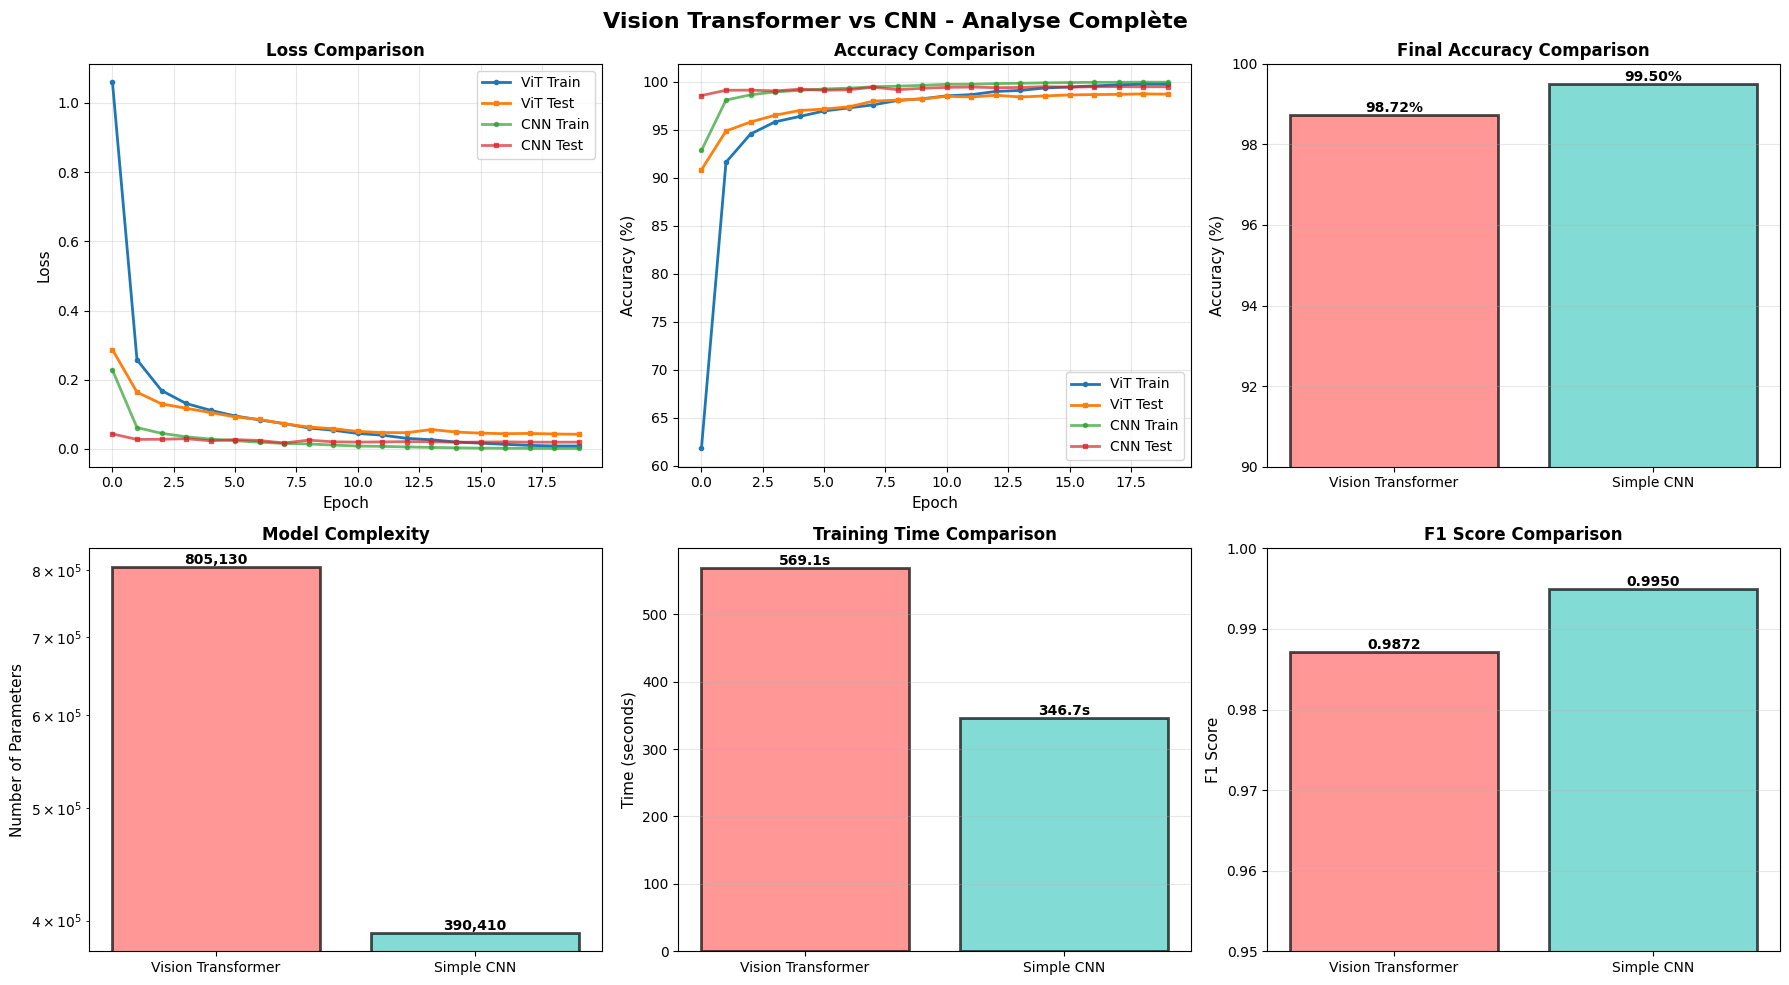

✓ Graph sauvegardé: 'confusion_matrices.png'


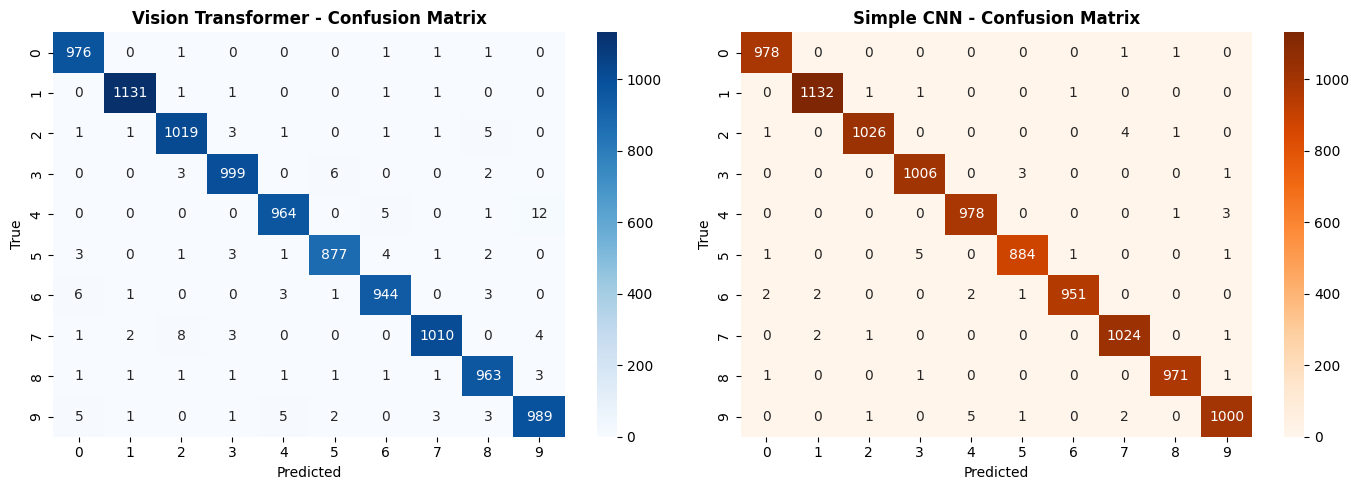


✓ EXÉCUTION TERMINÉE AVEC SUCCÈS!

Fichiers générés:
  - vit_vs_cnn_comparison.png
  - confusion_matrices.png


In [9]:
# ============================================================================
# VISUALISATION
# ============================================================================
print("\n" + "="*80)
print("GÉNÉRATIONS DES VISUALISATIONS")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Vision Transformer vs CNN - Analyse Complète', fontsize=16, fontweight='bold')

# Loss curves
axes[0, 0].plot(vit_results['train_losses'], label='ViT Train', linewidth=2, marker='o', markersize=3)
axes[0, 0].plot(vit_results['test_losses'], label='ViT Test', linewidth=2, marker='s', markersize=3)
axes[0, 0].plot(cnn_results['train_losses'], label='CNN Train', linewidth=2, marker='o', markersize=3, alpha=0.7)
axes[0, 0].plot(cnn_results['test_losses'], label='CNN Test', linewidth=2, marker='s', markersize=3, alpha=0.7)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss', fontsize=11)
axes[0, 0].set_title('Loss Comparison', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curves
axes[0, 1].plot(vit_results['train_accs'], label='ViT Train', linewidth=2, marker='o', markersize=3)
axes[0, 1].plot(vit_results['test_accs'], label='ViT Test', linewidth=2, marker='s', markersize=3)
axes[0, 1].plot(cnn_results['train_accs'], label='CNN Train', linewidth=2, marker='o', markersize=3, alpha=0.7)
axes[0, 1].plot(cnn_results['test_accs'], label='CNN Test', linewidth=2, marker='s', markersize=3, alpha=0.7)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=11)
axes[0, 1].set_title('Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Accuracy bar chart
models = ['Vision Transformer', 'Simple CNN']
accuracies = [vit_results['final_accuracy'], cnn_results['final_accuracy']]
colors = ['#FF6B6B', '#4ECDC4']
bars = axes[0, 2].bar(models, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0, 2].set_ylabel('Accuracy (%)', fontsize=11)
axes[0, 2].set_title('Final Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0, 2].set_ylim([90, 100])
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[0, 2].text(bar.get_x() + bar.get_width()/2., height,
                   f'{accuracies[i]:.2f}%', ha='center', va='bottom', fontweight='bold')
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Parameters comparison
params = [vit_results['parameters'], cnn_results['parameters']]
axes[1, 0].bar(models, params, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 0].set_ylabel('Number of Parameters', fontsize=11)
axes[1, 0].set_title('Model Complexity', fontsize=12, fontweight='bold')
axes[1, 0].set_yscale('log')
for i, p in enumerate(params):
    axes[1, 0].text(i, p, f'{p:,}', ha='center', va='bottom', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Training time
times = [vit_results['training_time'], cnn_results['training_time']]
axes[1, 1].bar(models, times, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 1].set_ylabel('Time (seconds)', fontsize=11)
axes[1, 1].set_title('Training Time Comparison', fontsize=12, fontweight='bold')
for i, t in enumerate(times):
    axes[1, 1].text(i, t, f'{t:.1f}s', ha='center', va='bottom', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# F1 Score
f1_scores = [vit_results['final_f1'], cnn_results['final_f1']]
axes[1, 2].bar(models, f1_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 2].set_ylabel('F1 Score', fontsize=11)
axes[1, 2].set_title('F1 Score Comparison', fontsize=12, fontweight='bold')
axes[1, 2].set_ylim([0.95, 1.0])
for i, f1 in enumerate(f1_scores):
    axes[1, 2].text(i, f1, f'{f1:.4f}', ha='center', va='bottom', fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('vit_vs_cnn_comparison.png', dpi=150, bbox_inches='tight')
print("✓ Graph sauvegardé: 'vit_vs_cnn_comparison.png'")
plt.show()

# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_vit = confusion_matrix(vit_results['labels'], vit_results['predictions'])
cm_cnn = confusion_matrix(cnn_results['labels'], cnn_results['predictions'])

sns.heatmap(cm_vit, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=True)
axes[0].set_title('Vision Transformer - Confusion Matrix', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Oranges', ax=axes[1], cbar=True)
axes[1].set_title('Simple CNN - Confusion Matrix', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
print("✓ Graph sauvegardé: 'confusion_matrices.png'")
plt.show()

print("\n" + "="*80)
print("✓ EXÉCUTION TERMINÉE AVEC SUCCÈS!")
print("="*80)
print("\nFichiers générés:")
print("  - vit_vs_cnn_comparison.png")
print("  - confusion_matrices.png")